
|Authors Name|ID      |
|------------|------- |
|Ben Allen   |18044679|
|Johney Jijin|18032679|
|Jamie Scott |18041508|

###### Imports and defaults

In [1]:
from IPython.core.display import display, HTML, Markdown as md
display(HTML("""<style>.container { width:100% !important; } p, ul {max-width: 40em;} .rendered_html table { margin-left: 0; } .output_subarea.output_png { display: flex; justify-content: center;}</style>"""))

import matplotlib.pyplot as plt
from pylab import rcParams
import pandas as pd
import seaborn as sns
import numpy as np

rcParams['figure.dpi'] = 350
rcParams['axes.labelsize'] = 'large'
rcParams['xtick.labelsize'] = 20
rcParams['ytick.labelsize'] = 20
rcParams['lines.linewidth'] = 2
rcParams['font.size'] = 18

%matplotlib inline
sns.set_style('darkgrid')
pd.set_option('max_columns', 100)
pd.set_option('max_rows', 20)

---

<center style="background: #f8f8f8;padding: 1rem;padding-bottom: 2.5rem;border-radius: 8px;">
<a id="Home"></a>

# "Can he/they/she do it on a cold, rainy night in Stoke"
## The myth of the unglamorous away fixture.

</center>

- [Introduction](#Introduction)
- [Research Question](#Research_Question)
- [Importing Data](#Importing_Data)
- [Cleaning and Wrangling](#Cleaning_and_Wrangling)
- [EDA](#EDA)
- [Data Sources](#Data_Sources)
- [References](#References)
- [Stuff we dont need just yet](#Extras)


- Import datasets
- Clean datasets
- whatever else

<a id="Introduction"></a>
## Introduction 

Nine years ago, just a few days before Christmas at the midpoint in the 2010/11 season, football commentator Andy Gray gave the football lexicon a small but lasting gift. He and Richard Keys were filling the time before kickoff in the televised Monday night match discussing the relative merits of two of the greatest players of all time, Lionel Messi and Cristiano Ronaldo who were going head-to-head for yet another award.

Depsite being full of praise for Messi, who played (and still does) for Barcelona in Spain's La Liga, Gray suggested the player many believe the best to play the game "would struggle on a cold night at the Britannia Staidium"$^{1}$, where Stoke City play their home games. For Stoke, it appeared a relatively generous assertion given they were hardly one of the best sides in England, let alone Europe.

The quote morphed and took on a life of its own. "Can he/they/she do it on a cold, rainy night in Stoke" has became a sometimes serious, often tongue-in-cheek benchmark for quality, especially in unfamiliar or unpleasant conditions even beyond the realm of football. Showing how serious the notion is sometimes taken, the Daily Telgraph named it one of the ten most enduring football debates,$^{2}$ while at the other end of the scale, the line even spawned its own video game.$^{3}$

Stoke spent 10 seasons in the top flight before being relegated to the second tier of English football at the end of the 2017/18 season but the meme lives on. Recently when English side knocked Barcelona out of the European Champions League, many twitter users saw it as evidence that Messi could not in fact do it on a cold night in Stoke, setting aside the fact that Stoke and Liverpool are in fact different places (and Messi and his teammates have knocked plenty of English and Scottish sides out of the Champions League). Nonetheless it piqued our interest in the math behind the myth.


In [2]:
from IPython.core.display import HTML 
HTML("<iframe src=https://www.telegraph.co.uk/sport/11611106/The-10-most-enduring-football-debates.html?frame=3307440 width=1200 height=600></iframe>")

/anaconda3/lib/python3.7/site-packages/IPython/core/display.py:689: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


<a id="Research_Question"></a>
## Research question
Driving this report is the exploration of the following question:
> Is there any validity to the notion that an away fixture on a cold, wet night in Stoke is a tough fixture?

Firstly we'll examine some of the reasons why Stoke of all places was singled out in this otherwise throwaway comment. Is it particularly cold or wet? Are there other factors that might contrbute to it being a tough away match?

Next, we'll dive deeper into just how difficult a fixture away to Stoke was, based on results from their ten year stay on the Prmeier League. Did they become harder to beat when in cold or wet weather? Or at night? Or maybe a given a combination of those things. Crucially, were they harder to beat than other teams.

Finally we'll use machine learning to .....DO SOMETHING COOL OR INTERESTING




<a id="Importing_Data"></a>
## Importing datasets - (heading just for internal use at this stage)

The Premier League data we worked with came from two sources with essentially the same core information but two important differences. One had more detailed information including fouls, shot along with red and yellow cards while another had attendance and a key ingredient for our analysis... kickoff time.

In [3]:
#import smaller dataset from 07/08 - 17/18 that contains time info
DatasetOne = pd.read_csv("./epl_data.csv")
DatasetOne.head()

,Match_ID,Team_Home,Team_Away,HG,AG,X/U,Season,Date_Time,Referee_Name,Att,BBC_Football_URL,Sky_Sports_URL
0,12,Sunderland,Tottenham Hotspur,1,0,X,2007/2008,11/08/2007 12:45,Alan Wiley,43967,http://news.bbc.co.uk/sport1/hi/football/eng_p...,http://www.skysports.com/football/sland-vs-tot...
1,13,Bolton Wanderers,Newcastle United,1,3,X,2007/2008,11/08/2007 15:00,Chris Foy,25414,http://news.bbc.co.uk/sport1/hi/football/eng_p...,http://www.skysports.com/football/bolton-vs-ne...
2,14,Derby County,Portsmouth,2,2,X,2007/2008,11/08/2007 15:00,Mike Dean,32176,http://news.bbc.co.uk/sport1/hi/football/eng_p...,http://www.skysports.com/football/derby-vs-por...
3,15,Everton,Wigan Athletic,2,1,X,2007/2008,11/08/2007 15:00,Mark Clattenburg,39220,http://news.bbc.co.uk/sport1/hi/football/eng_p...,http://www.skysports.com/football/everton-vs-w...
4,16,Middlesbrough,Blackburn Rovers,1,2,X,2007/2008,11/08/2007 15:00,Andre Marriner,25058,http://news.bbc.co.uk/sport1/hi/football/eng_p...,http://www.skysports.com/football/mboro-vs-bla...


In [4]:
#import bigger dataset that has extra info but not time data
DatasetTwo = pd.read_csv("./EPL 2000-2018.csv")
DatasetTwo.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,Season
0,19/08/00,Charlton,Man City,4.0,0.0,H,2.0,0.0,H,Rob Harris,17.0,8.0,14.0,4.0,13.0,12.0,6.0,6.0,1.0,2.0,0.0,0.0,00-01
1,19/08/00,Chelsea,West Ham,4.0,2.0,H,1.0,0.0,H,Graham Barber,17.0,12.0,10.0,5.0,19.0,14.0,7.0,7.0,1.0,2.0,0.0,0.0,00-01
2,19/08/00,Coventry,Middlesbrough,1.0,3.0,A,1.0,1.0,D,Barry Knight,6.0,16.0,3.0,9.0,15.0,21.0,8.0,4.0,5.0,3.0,1.0,0.0,00-01
3,19/08/00,Derby,Southampton,2.0,2.0,D,1.0,2.0,A,Andy D'Urso,6.0,13.0,4.0,6.0,11.0,13.0,5.0,8.0,1.0,1.0,0.0,0.0,00-01
4,19/08/00,Leeds,Everton,2.0,0.0,H,2.0,0.0,H,Dermot Gallagher,17.0,12.0,8.0,6.0,21.0,20.0,6.0,4.0,1.0,3.0,0.0,0.0,00-01


In [5]:
DatasetOne.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4180 entries, 0 to 4179
Data columns (total 12 columns):
Match_ID            4180 non-null int64
Team_Home           4180 non-null object
Team_Away           4180 non-null object
HG                  4180 non-null int64
AG                  4180 non-null int64
X/U                 4180 non-null object
Season              4180 non-null object
Date_Time           4180 non-null object
Referee_Name        4180 non-null object
Att                 4180 non-null int64
BBC_Football_URL    4180 non-null object
Sky_Sports_URL      4180 non-null object
dtypes: int64(4), object(8)
memory usage: 392.0+ KB


In [6]:
DatasetTwo.info()
#note extra non-null entry for season and floats instead of ints

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6461 entries, 0 to 6460
Data columns (total 23 columns):
Date        6460 non-null object
HomeTeam    6460 non-null object
AwayTeam    6460 non-null object
FTHG        6460 non-null float64
FTAG        6460 non-null float64
FTR         6460 non-null object
HTHG        6460 non-null float64
HTAG        6460 non-null float64
HTR         6460 non-null object
Referee     6460 non-null object
HS          6460 non-null float64
AS          6460 non-null float64
HST         6460 non-null float64
AST         6460 non-null float64
HF          6460 non-null float64
AF          6460 non-null float64
HC          6460 non-null float64
AC          6460 non-null float64
HY          6460 non-null float64
AY          6460 non-null float64
HR          6460 non-null float64
AR          6460 non-null float64
Season      6461 non-null object
dtypes: float64(16), object(7)
memory usage: 1.1+ MB


<a id="Cleaning_and_Wrangling"></a>
## Clean datasets

In [7]:
#There's an extra non-null entry in the Season column - check if it's a rogue entry
DatasetTwo.Season.unique()

array(['00-01', '02-03', '03-04', '04-05', '05-06', '06-07', '07-08',
       '08-09', '09-10', '10-11', '11-12', '12-13', '13-14', '14-15',
       '15-16', '16-17', '17-18'], dtype=object)

In [8]:
# DatasetTwo.isnull().sum()

In [9]:
#find row with extra entry 
DatasetTwo[DatasetTwo.HomeTeam.isnull()]

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,Season
5320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14-15


In [10]:
#make sure there's 380 fixtures for the 14-15 season. There's 381, we can delete.
DatasetTwo[DatasetTwo.Season == '14-15']

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,Season
4940,16/08/14,Arsenal,Crystal Palace,2.0,1.0,H,1.0,1.0,D,J Moss,14.0,4.0,6.0,2.0,13.0,19.0,9.0,3.0,2.0,2.0,0.0,1.0,14-15
4941,16/08/14,Leicester,Everton,2.0,2.0,D,1.0,2.0,A,M Jones,11.0,13.0,3.0,3.0,16.0,10.0,3.0,6.0,1.0,1.0,0.0,0.0,14-15
4942,16/08/14,Man United,Swansea,1.0,2.0,A,0.0,1.0,A,M Dean,14.0,5.0,5.0,4.0,14.0,20.0,4.0,0.0,2.0,4.0,0.0,0.0,14-15
4943,16/08/14,QPR,Hull,0.0,1.0,A,0.0,0.0,D,C Pawson,19.0,11.0,6.0,4.0,10.0,10.0,8.0,9.0,1.0,2.0,0.0,0.0,14-15
4944,16/08/14,Stoke,Aston Villa,0.0,1.0,A,0.0,0.0,D,A Taylor,12.0,7.0,2.0,2.0,14.0,9.0,2.0,8.0,0.0,3.0,0.0,0.0,14-15
4945,16/08/14,West Brom,Sunderland,2.0,2.0,D,1.0,1.0,D,N Swarbrick,10.0,7.0,5.0,2.0,18.0,9.0,6.0,3.0,3.0,1.0,0.0,0.0,14-15
4946,16/08/14,West Ham,Tottenham,0.0,1.0,A,0.0,0.0,D,C Foy,18.0,10.0,4.0,4.0,12.0,10.0,8.0,5.0,1.0,0.0,1.0,1.0,14-15
4947,17/08/14,Liverpool,Southampton,2.0,1.0,H,1.0,0.0,H,M Clattenburg,12.0,12.0,5.0,6.0,8.0,11.0,2.0,6.0,1.0,2.0,0.0,0.0,14-15
4948,17/08/14,Newcastle,Man City,0.0,2.0,A,0.0,1.0,A,M Atkinson,12.0,13.0,0.0,5.0,8.0,11.0,3.0,3.0,1.0,5.0,0.0,0.0,14-15
4949,18/08/14,Burnley,Chelsea,1.0,3.0,A,1.0,3.0,A,M Oliver,9.0,11.0,2.0,3.0,6.0,7.0,4.0,3.0,1.0,1.0,0.0,0.0,14-15


In [11]:
DatasetOne.drop(['X/U', 'BBC_Football_URL', 'Sky_Sports_URL'], axis=1, inplace=True)

SeasonstoDelete = ['00-01', '02-03', '03-04', '04-05', '05-06', '06-07']
RowsToDelete = list(row for row in list(DatasetTwo.index) if DatasetTwo.Season[row] in SeasonstoDelete)
DatasetTwo.drop(RowsToDelete+[5320], inplace=True)
del DatasetTwo['Referee']

In [12]:
DatasetOne.Season.unique()

array(['2007/2008', '2008/2009', '2009/2010', '2010/2011', '2011/2012',
       '2012/2013', '2013/2014', '2014/2015', '2015/2016', '2016/2017',
       '2017/2018'], dtype=object)

In [13]:
#renaming in DatasetOne for consistency with datasetTwo to help with merging
DatasetOne.columns = ['Match_ID', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'Season', 'Date_Time',
       'Referee', 'Att']

In [14]:
# dict to align season values between datasets
SeasonDict = {'2007/2008':'07-08', '2008/2009':'08-09', '2009/2010':'09-10', '2010/2011':'10-11', '2011/2012':'11-12', 
              '2012/2013':'12-13', '2013/2014':'13-14', '2014/2015':'14-15', '2015/2016':'15-16', '2016/2017':'16-17',
              '2017/2018':'17-18'}

#create a dict to align team names in HomeTeam and AwayTeam columns
differentnamesOne = [country for country in list(DatasetOne.HomeTeam.unique()) if country not in list(DatasetTwo.HomeTeam.unique())]
differentnamesTwo = [country for country in list(DatasetTwo.HomeTeam.unique()) if country not in list(DatasetOne.HomeTeam.unique())]

renameTeams = {}
for i, name in enumerate(differentnamesOne):
    renameTeams.update({differentnamesTwo[i]:differentnamesOne[i]})

DatasetOne.replace({'Season':SeasonDict}, inplace=True)
DatasetTwo.replace({'HomeTeam':renameTeams, 'AwayTeam':renameTeams}, inplace=True)

In [15]:
for col in list(DatasetTwo.columns):
    if DatasetTwo[col].dtype == 'float64':
        DatasetTwo[col] = DatasetTwo[col].astype('int64')

In [16]:
DatasetOne.head()

,Match_ID,HomeTeam,AwayTeam,FTHG,FTAG,Season,Date_Time,Referee,Att
0,12,Sunderland,Tottenham Hotspur,1,0,07-08,11/08/2007 12:45,Alan Wiley,43967
1,13,Bolton Wanderers,Newcastle United,1,3,07-08,11/08/2007 15:00,Chris Foy,25414
2,14,Derby County,Portsmouth,2,2,07-08,11/08/2007 15:00,Mike Dean,32176
3,15,Everton,Wigan Athletic,2,1,07-08,11/08/2007 15:00,Mark Clattenburg,39220
4,16,Middlesbrough,Blackburn Rovers,1,2,07-08,11/08/2007 15:00,Andre Marriner,25058


In [17]:
DatasetTwo.reset_index(inplace=True)
DatasetTwo.head()

,index,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,Season
0,2280,11/08/07,Aston Villa,Liverpool,1,2,A,0,1,A,10,17,6,7,18,11,4,2,4,2,0,0,07-08
1,2281,11/08/07,Bolton Wanderers,Newcastle United,1,3,A,0,3,A,13,7,9,5,15,16,4,3,1,1,0,0,07-08
2,2282,11/08/07,Derby County,Portsmouth,2,2,D,1,1,D,12,12,5,6,14,17,6,6,1,2,0,0,07-08
3,2283,11/08/07,Everton,Wigan Athletic,2,1,H,1,0,H,12,14,8,4,8,13,6,2,0,0,0,0,07-08
4,2284,11/08/07,Middlesbrough,Blackburn Rovers,1,2,A,1,0,H,10,4,6,4,16,16,13,3,3,4,0,0,07-08


In [18]:
DatasetOne.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4180 entries, 0 to 4179
Data columns (total 9 columns):
Match_ID     4180 non-null int64
HomeTeam     4180 non-null object
AwayTeam     4180 non-null object
FTHG         4180 non-null int64
FTAG         4180 non-null int64
Season       4180 non-null object
Date_Time    4180 non-null object
Referee      4180 non-null object
Att          4180 non-null int64
dtypes: int64(4), object(5)
memory usage: 294.0+ KB


In [19]:
DatasetTwo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4180 entries, 0 to 4179
Data columns (total 23 columns):
index       4180 non-null int64
Date        4180 non-null object
HomeTeam    4180 non-null object
AwayTeam    4180 non-null object
FTHG        4180 non-null int64
FTAG        4180 non-null int64
FTR         4180 non-null object
HTHG        4180 non-null int64
HTAG        4180 non-null int64
HTR         4180 non-null object
HS          4180 non-null int64
AS          4180 non-null int64
HST         4180 non-null int64
AST         4180 non-null int64
HF          4180 non-null int64
AF          4180 non-null int64
HC          4180 non-null int64
AC          4180 non-null int64
HY          4180 non-null int64
AY          4180 non-null int64
HR          4180 non-null int64
AR          4180 non-null int64
Season      4180 non-null object
dtypes: int64(17), object(6)
memory usage: 751.2+ KB


In [20]:
# print(DatasetOne.HomeTeam.unique())
# print('--------')
# print(DatasetTwo.HomeTeam.unique())

In [21]:
# DatasetTwo.info()

In [22]:
PremierLeague = pd.merge(DatasetOne, DatasetTwo)

In [23]:
PremierLeague.head()

,Match_ID,HomeTeam,AwayTeam,FTHG,FTAG,Season,Date_Time,Referee,Att,index,Date,FTR,HTHG,HTAG,HTR,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
0,12,Sunderland,Tottenham Hotspur,1,0,07-08,11/08/2007 12:45,Alan Wiley,43967,2285,11/08/07,H,0,0,D,9,6,4,3,14,14,7,2,1,1,0,0
1,13,Bolton Wanderers,Newcastle United,1,3,07-08,11/08/2007 15:00,Chris Foy,25414,2281,11/08/07,A,0,3,A,13,7,9,5,15,16,4,3,1,1,0,0
2,14,Derby County,Portsmouth,2,2,07-08,11/08/2007 15:00,Mike Dean,32176,2282,11/08/07,D,1,1,D,12,12,5,6,14,17,6,6,1,2,0,0
3,15,Everton,Wigan Athletic,2,1,07-08,11/08/2007 15:00,Mark Clattenburg,39220,2283,11/08/07,H,1,0,H,12,14,8,4,8,13,6,2,0,0,0,0
4,16,Middlesbrough,Blackburn Rovers,1,2,07-08,11/08/2007 15:00,Andre Marriner,25058,2284,11/08/07,A,1,0,H,10,4,6,4,16,16,13,3,3,4,0,0


In [24]:
PremierLeague.info()

### ONE MATCH IS MISSING - MUST BE A DIFFERENT SCORE IN EACH DATASET ##

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4179 entries, 0 to 4178
Data columns (total 27 columns):
Match_ID     4179 non-null int64
HomeTeam     4179 non-null object
AwayTeam     4179 non-null object
FTHG         4179 non-null int64
FTAG         4179 non-null int64
Season       4179 non-null object
Date_Time    4179 non-null object
Referee      4179 non-null object
Att          4179 non-null int64
index        4179 non-null int64
Date         4179 non-null object
FTR          4179 non-null object
HTHG         4179 non-null int64
HTAG         4179 non-null int64
HTR          4179 non-null object
HS           4179 non-null int64
AS           4179 non-null int64
HST          4179 non-null int64
AST          4179 non-null int64
HF           4179 non-null int64
AF           4179 non-null int64
HC           4179 non-null int64
AC           4179 non-null int64
HY           4179 non-null int64
AY           4179 non-null int64
HR           4179 non-null int64
AR           4179 non-null 

In [25]:
seasoncount = []
for year in list(PremierLeague.Season.unique()):
    seasoncount.append((year, PremierLeague[PremierLeague.Season == year].Date.count()))
seasoncount

#14-15

PL1415 = PremierLeague[PremierLeague.Season == '14-15']

teamHcount = []
for team in list(PL1415.HomeTeam.unique()):
    teamHcount.append((team, PL1415[PL1415.HomeTeam == team].Date.count()))
teamHcount

#Tottenham


teamAcount = []
for team in list(PL1415.AwayTeam.unique()):
    teamAcount.append((team, PL1415[PL1415.AwayTeam == team].Date.count()))
teamAcount

#Tottenham v Man City

# print(DatasetOne[DatasetOne.Season == '14-15'][DatasetOne.HomeTeam == 'Tottenham'][DatasetOne.AwayTeam == 'Man City'])
# print(DatasetTwo[DatasetTwo.Season == '14-15'][DatasetTwo.HomeTeam == 'Tottenham'][DatasetTwo.AwayTeam == 'Man City'])

#score around the wrong way. Checked online to see which one was incorrect. Score in dataset 1 needed to change.

DatasetOne.at[3007, 'FTHG'] = 0
DatasetOne.at[3007, 'FTAG'] = 1
DatasetOne.iloc[3007]

Match_ID                  3151
HomeTeam     Tottenham Hotspur
AwayTeam       Manchester City
FTHG                         0
FTAG                         1
Season                   14-15
Date_Time     03/05/2015 16:00
Referee         Andre Marriner
Att                      35784
Name: 3007, dtype: object

In [94]:
#merge again.
PremierLeague = pd.merge(DatasetOne, DatasetTwo)

In [95]:
PremierLeague.info()
#4180 entries. All good.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4180 entries, 0 to 4179
Data columns (total 27 columns):
Match_ID     4180 non-null int64
HomeTeam     4180 non-null object
AwayTeam     4180 non-null object
FTHG         4180 non-null int64
FTAG         4180 non-null int64
Season       4180 non-null object
Date_Time    4180 non-null object
Referee      4180 non-null object
Att          4180 non-null int64
index        4180 non-null int64
Date         4180 non-null object
FTR          4180 non-null object
HTHG         4180 non-null int64
HTAG         4180 non-null int64
HTR          4180 non-null object
HS           4180 non-null int64
AS           4180 non-null int64
HST          4180 non-null int64
AST          4180 non-null int64
HF           4180 non-null int64
AF           4180 non-null int64
HC           4180 non-null int64
AC           4180 non-null int64
HY           4180 non-null int64
AY           4180 non-null int64
HR           4180 non-null int64
AR           4180 non-null 

In [96]:
PremierLeague.head()

,Match_ID,HomeTeam,AwayTeam,FTHG,FTAG,Season,Date_Time,Referee,Att,index,Date,FTR,HTHG,HTAG,HTR,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
0,12,Sunderland,Tottenham Hotspur,1,0,07-08,11/08/2007 12:45,Alan Wiley,43967,2285,11/08/07,H,0,0,D,9,6,4,3,14,14,7,2,1,1,0,0
1,13,Bolton Wanderers,Newcastle United,1,3,07-08,11/08/2007 15:00,Chris Foy,25414,2281,11/08/07,A,0,3,A,13,7,9,5,15,16,4,3,1,1,0,0
2,14,Derby County,Portsmouth,2,2,07-08,11/08/2007 15:00,Mike Dean,32176,2282,11/08/07,D,1,1,D,12,12,5,6,14,17,6,6,1,2,0,0
3,15,Everton,Wigan Athletic,2,1,07-08,11/08/2007 15:00,Mark Clattenburg,39220,2283,11/08/07,H,1,0,H,12,14,8,4,8,13,6,2,0,0,0,0
4,16,Middlesbrough,Blackburn Rovers,1,2,07-08,11/08/2007 15:00,Andre Marriner,25058,2284,11/08/07,A,1,0,H,10,4,6,4,16,16,13,3,3,4,0,0


In [97]:
PremierLeague.drop(['Match_ID', 'index', 'Date', 'HTHG', 'HTAG', 'HTR', 'Referee'], axis=1, inplace=True)
PremierLeague.columns = ['HomeTeam', 'AwayTeam', 'HomeScore', 'AwayScore', 'Season', 'Date_Time', 'Attendance',
                         'Result','HomeShots', 'AwayShots', 'HomeShotsOnTarget', 'AwayShotsOnTarget', 'HomeFouls', 
                         'AwayFouls','HomeCorners', 'AwayCorners', 'HomeYellows', 'AwayYellows', 
                         'HomeReds', 'AwayReds']

In [98]:
PremierLeague.HomeTeam.unique()

array(['Sunderland', 'Bolton Wanderers', 'Derby County', 'Everton',
       'Middlesbrough', 'West Ham United', 'Aston Villa', 'Arsenal',
       'Chelsea', 'Manchester United', 'Tottenham Hotspur',
       'Birmingham City', 'Fulham', 'Manchester City', 'Portsmouth',
       'Reading', 'Wigan Athletic', 'Newcastle United',
       'Blackburn Rovers', 'Liverpool', 'Hull City', 'Stoke City',
       'West Bromwich Albion', 'Wolverhampton Wanderers', 'Burnley',
       'Blackpool', 'Queens Park Rangers', 'Swansea City', 'Norwich City',
       'Southampton', 'Crystal Palace', 'Cardiff City', 'Leicester City',
       'Bournemouth', 'Watford', 'Brighton & Hove Albion',
       'Huddersfield Town'], dtype=object)

In [99]:
ClubCities ={'Sunderland':'Sunderland', 'Bolton Wanderers':'Bolton', 'Derby County':'Derby', 'Everton':'Liverpool', 'Middlesbrough':'Middlesbrough',
             'West Ham United':'London', 'Aston Villa':'Birmingham', 'Arsenal':'London', 'Chelsea':'London', 'Manchester United':'Trafford', 
             'Tottenham Hotspur':'London', 'Birmingham City':'Birmingham', 'Fulham':'London', 'Manchester City':'Manchester', 'Portsmouth':'Portsmouth',
             'Reading':'Reading', 'Wigan Athletic': 'Wigan', 'Newcastle United':'Newcastle upon Tyne', 'Blackburn Rovers':'Blackburn', 'Liverpool':'Liverpool', 
             'Hull City':'Hull', 'Stoke':'Stoke-on-Trent', 'West Bromwich Albion':'West Bromwich', 'Wolverhampton Wanderers':'Wolverhampton', 
             'Burnley':'Burnley', 'Blackpool':'Blackpool', 'Queens Park Rangers':'London', 'Swansea City':'Swansea', 'Norwich City':'Norwich', 
             'Southampton':'Southampton', 'Crystal Palace':'London', 'Cardiff City':'Cardiff', 'Leicester City':'Leicester', 'Bournemouth':'Bournemouth', 
             'Watford':'Watford', 'Brighton & Hove Albion':'Falmer', 'Huddersfield Town':'Huddersfield', 'Stoke City': 'Stoke-on-Trent'}

ResultClass = {'H':0, 'D':1, 'A':2}

def home_points_cal(row):
    if row['HomeScore'] > row['AwayScore']:
        return 3
    elif row ['HomeScore']==row['AwayScore']:
        return 1    
    else: 
        return 0

def away_points_cal(row):
    if row['HomeScore'] < row['AwayScore']:
        return 3
    elif row ['HomeScore']==row['AwayScore']:
        return 1    
    else: 
        return 0

In [100]:
PremierLeague['City']=PremierLeague['HomeTeam'].map(ClubCities)
PremierLeague['Result_Class']=PremierLeague['Result'].map(ResultClass)
PremierLeague['HomePoints']=PremierLeague.apply(home_points_cal,axis=1)
PremierLeague['AwayPoints']=PremierLeague.apply(away_points_cal,axis=1)
PremierLeague.head(5)

,HomeTeam,AwayTeam,HomeScore,AwayScore,Season,Date_Time,Attendance,Result,HomeShots,AwayShots,HomeShotsOnTarget,AwayShotsOnTarget,HomeFouls,AwayFouls,HomeCorners,AwayCorners,HomeYellows,AwayYellows,HomeReds,AwayReds,City,Result_Class,HomePoints,AwayPoints
0,Sunderland,Tottenham Hotspur,1,0,07-08,11/08/2007 12:45,43967,H,9,6,4,3,14,14,7,2,1,1,0,0,Sunderland,0,3,0
1,Bolton Wanderers,Newcastle United,1,3,07-08,11/08/2007 15:00,25414,A,13,7,9,5,15,16,4,3,1,1,0,0,Bolton,2,0,3
2,Derby County,Portsmouth,2,2,07-08,11/08/2007 15:00,32176,D,12,12,5,6,14,17,6,6,1,2,0,0,Derby,1,1,1
3,Everton,Wigan Athletic,2,1,07-08,11/08/2007 15:00,39220,H,12,14,8,4,8,13,6,2,0,0,0,0,Liverpool,0,3,0
4,Middlesbrough,Blackburn Rovers,1,2,07-08,11/08/2007 15:00,25058,A,10,4,6,4,16,16,13,3,3,4,0,0,Middlesbrough,2,0,3


#### Get weather data 
Now that the city column is set we can use the city to search for the weather

Following cells are left as not executable to avoid hitting the API each time

In [101]:
weather = pd.read_csv("./cities_dates.csv", index_col=0)

In [102]:
## Clean weather data
# drop nan values (fixtures before 1st July 2008 will not have weather data)
# merge into PremierLeague DataFrame
# remove duplicate rows for London games (created in merge since there are multiple games in London for any given day/time combo) 
# convert Date_Time into python datetime

PremierLeague = PremierLeague.merge(weather, on=['City', 'Date_Time'], how='outer')
PremierLeague.drop_duplicates(subset=None, keep='first', inplace=True)

In [103]:
PremierLeague['Date_Time'] = pd.to_datetime(PremierLeague['Date_Time'], dayfirst=True)
PremierLeague['DayofWeek'] = PremierLeague['Date_Time'].dt.day_name()
PremierLeague['Date']= pd.to_datetime(PremierLeague['Date_Time'].dt.date)
PremierLeague['Kickoff']=PremierLeague['Date_Time'].dt.time
PremierLeague.drop(['Date_Time'], axis=1, inplace=True)
PremierLeague.head()

,HomeTeam,AwayTeam,HomeScore,AwayScore,Season,Attendance,Result,HomeShots,AwayShots,HomeShotsOnTarget,AwayShotsOnTarget,HomeFouls,AwayFouls,HomeCorners,AwayCorners,HomeYellows,AwayYellows,HomeReds,AwayReds,City,Result_Class,HomePoints,AwayPoints,MintempC,MaxtempC,TempC,WindspeedKmph,WeatherDesc,WinddirDegree,Winddir16Point,PrecipMM,Humidity,Visibility,Pressure,Cloudcover,HeatIndexC,DewPointC,WindChillC,WindGustKmph,FeelsLikeC,UvIndex,DayofWeek,Date,Kickoff
0,Sunderland,Tottenham Hotspur,1,0,07-08,43967,H,9,6,4,3,14,14,7,2,1,1,0,0,Sunderland,0,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Saturday,2007-08-11,12:45:00
1,Bolton Wanderers,Newcastle United,1,3,07-08,25414,A,13,7,9,5,15,16,4,3,1,1,0,0,Bolton,2,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Saturday,2007-08-11,15:00:00
2,Derby County,Portsmouth,2,2,07-08,32176,D,12,12,5,6,14,17,6,6,1,2,0,0,Derby,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Saturday,2007-08-11,15:00:00
3,Everton,Wigan Athletic,2,1,07-08,39220,H,12,14,8,4,8,13,6,2,0,0,0,0,Liverpool,0,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Saturday,2007-08-11,15:00:00
4,Middlesbrough,Blackburn Rovers,1,2,07-08,25058,A,10,4,6,4,16,16,13,3,3,4,0,0,Middlesbrough,2,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Saturday,2007-08-11,15:00:00


In [104]:
PremierLeague= PremierLeague[['Season', 'Date', 'Kickoff', 'HomeTeam', 'AwayTeam', 'HomeScore', 'AwayScore', 'HomePoints', 'AwayPoints','Result','Result_Class', 'City',
                              'Attendance', 'DayofWeek', 'HomeShots', 'AwayShots', 'HomeShotsOnTarget', 'AwayShotsOnTarget', 'HomeFouls', 'AwayFouls',
                              'HomeCorners', 'AwayCorners', 'HomeYellows', 'AwayYellows', 'HomeReds', 'AwayReds', 'MintempC','MaxtempC','TempC', 
                              'WindspeedKmph','WeatherDesc', 'WinddirDegree', 'Winddir16Point', 'PrecipMM', 'Humidity', 'Visibility', 'Pressure', 
                              'Cloudcover', 'HeatIndexC', 'DewPointC','WindChillC', 'WindGustKmph', 'FeelsLikeC', 'UvIndex']]
PremierLeague.head()

,Season,Date,Kickoff,HomeTeam,AwayTeam,HomeScore,AwayScore,HomePoints,AwayPoints,Result,Result_Class,City,Attendance,DayofWeek,HomeShots,AwayShots,HomeShotsOnTarget,AwayShotsOnTarget,HomeFouls,AwayFouls,HomeCorners,AwayCorners,HomeYellows,AwayYellows,HomeReds,AwayReds,MintempC,MaxtempC,TempC,WindspeedKmph,WeatherDesc,WinddirDegree,Winddir16Point,PrecipMM,Humidity,Visibility,Pressure,Cloudcover,HeatIndexC,DewPointC,WindChillC,WindGustKmph,FeelsLikeC,UvIndex
0,07-08,2007-08-11,12:45:00,Sunderland,Tottenham Hotspur,1,0,3,0,H,0,Sunderland,43967,Saturday,9,6,4,3,14,14,7,2,1,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,07-08,2007-08-11,15:00:00,Bolton Wanderers,Newcastle United,1,3,0,3,A,2,Bolton,25414,Saturday,13,7,9,5,15,16,4,3,1,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,07-08,2007-08-11,15:00:00,Derby County,Portsmouth,2,2,1,1,D,1,Derby,32176,Saturday,12,12,5,6,14,17,6,6,1,2,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,07-08,2007-08-11,15:00:00,Everton,Wigan Athletic,2,1,3,0,H,0,Liverpool,39220,Saturday,12,14,8,4,8,13,6,2,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,07-08,2007-08-11,15:00:00,Middlesbrough,Blackburn Rovers,1,2,0,3,A,2,Middlesbrough,25058,Saturday,10,4,6,4,16,16,13,3,3,4,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
# PremierLeague.info()

<a id="EDA"></a>
## EDA

In [105]:
Club_Pts=PremierLeague[['Season', 'Date','HomeTeam','AwayTeam','HomeScore','AwayScore', 'Result','Attendance','HomePoints','AwayPoints', 'AwayShots', 'AwayShotsOnTarget', 'HomeFouls', 'HomeYellows']]
Home_Pts=pd.DataFrame(Club_Pts.groupby(['Season','HomeTeam'])['HomePoints', 'Attendance'].mean())
Home_Pts.reset_index(inplace=True)
Home_Pts=Home_Pts.rename(columns={'HomeTeam':'Team', 'HomePoints':'HomePPG','Attendance':'AvgAttendance'})
Home_Pts2=pd.DataFrame(Club_Pts.groupby(['Season','HomeTeam'])['HomePoints'].sum())
Home_Pts2.reset_index(inplace=True)
Home_Pts2=Home_Pts2.rename(columns={'HomeTeam':'Team'})
Home_Pts = pd.merge(Home_Pts2, Home_Pts)
Away_Pts=pd.DataFrame(Club_Pts.groupby(['Season','AwayTeam'])['AwayPoints', 'AwayShots', 'AwayShotsOnTarget', 'HomeFouls', 'HomeYellows' ].mean())
Away_Pts.reset_index(inplace=True)
Away_Pts=Away_Pts.rename(columns={'AwayTeam':'Team', 'AwayPoints':'AwayPPG', 'HomeFouls':'FoulsDrawnAway', 'HomeYellows':'OppYellowsAway'})
Away_Pts2 = pd.DataFrame(Club_Pts.groupby(['Season','AwayTeam'])['AwayPoints'].sum())
Away_Pts2.reset_index(inplace=True)
Away_Pts2=Away_Pts2.rename(columns={'AwayTeam':'Team'})
Away_Pts = pd.merge(Away_Pts2, Away_Pts)
Club_Pts=pd.merge(Home_Pts,  Away_Pts)
Club_Pts.head()

,Season,Team,HomePoints,HomePPG,AvgAttendance,AwayPoints,AwayPPG,AwayShots,AwayShotsOnTarget,FoulsDrawnAway,OppYellowsAway
0,07-08,Arsenal,47,2.473684,60070.263158,36,1.894737,13.315789,7.315789,13.105263,1.789474
1,07-08,Aston Villa,33,1.736842,40345.263158,27,1.421053,10.473684,6.315789,12.315789,1.631579
2,07-08,Birmingham City,26,1.368421,26180.947368,9,0.473684,7.157895,3.842105,10.684211,1.000000
3,07-08,Blackburn Rovers,31,1.631579,23943.578947,27,1.421053,10.473684,6.263158,14.105263,1.736842
4,07-08,Bolton Wanderers,26,1.368421,20901.157895,11,0.578947,8.947368,5.105263,13.052632,1.210526


In [106]:
HomeMedian = Club_Pts.HomePPG.median()
AwayMedian = Club_Pts.AwayPPG.median()

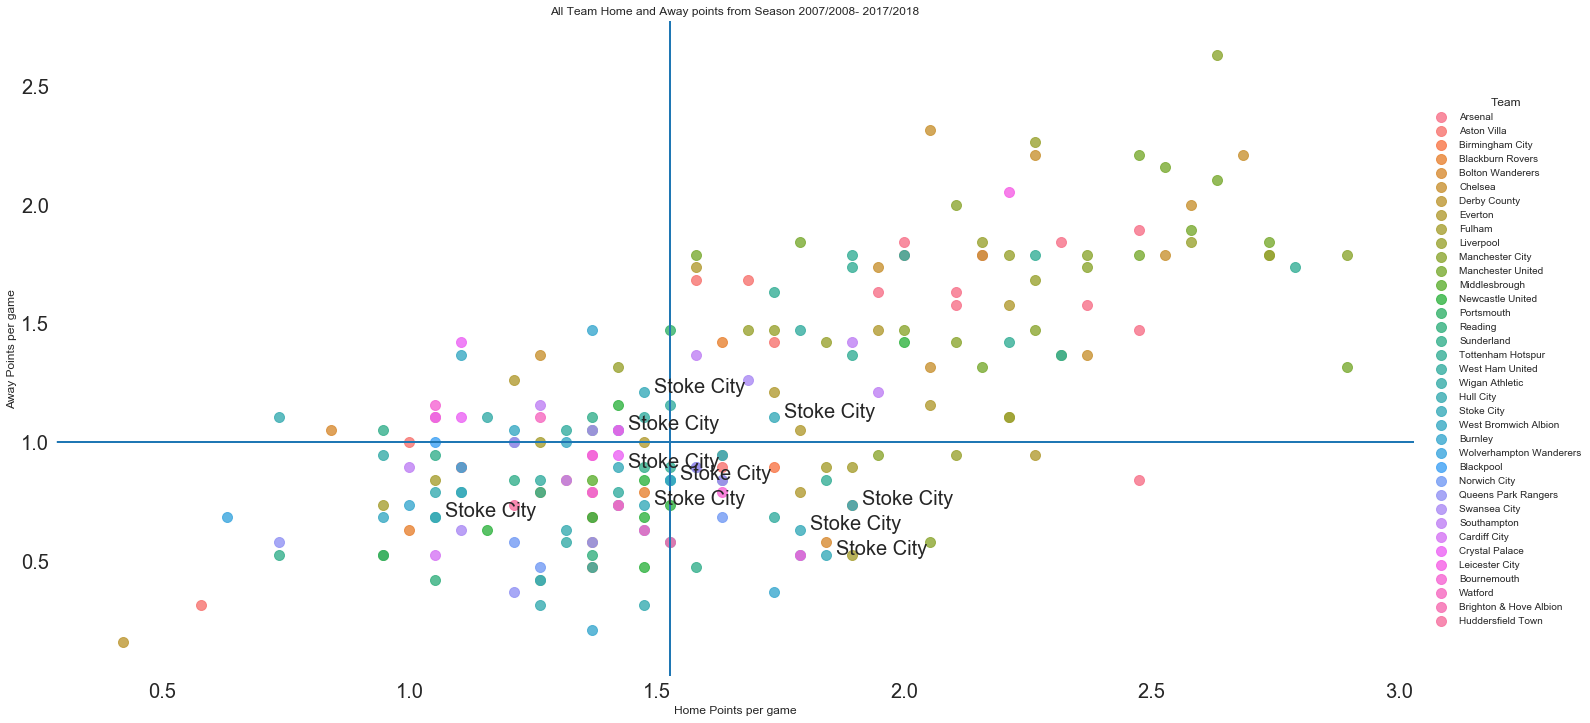

In [107]:
plt.rcParams['axes.facecolor'] = 'w'
rcParams['figure.figsize'] = 20,15
rcParams["scatter.marker"]='s'
ax = sns.lmplot('HomePPG','AwayPPG',data=Club_Pts,fit_reg=False, height = 10,aspect =2,hue='Team',scatter_kws={"s": 100})
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        if point['val']=='Stoke City':
            ax.text(point['x']+.02, point['y'], str(point['val']),fontsize=20)
            
plt.axvline(HomeMedian)
plt.axhline(AwayMedian)
  
plt.title('All Team Home and Away points from Season 2007/2008- 2017/2018')
# Set x-axis label
plt.xlabel('Home Points per game')
# Set y-axis label
plt.ylabel('Away Points per game')
 


label_point(Club_Pts.HomePPG, Club_Pts.AwayPPG, Club_Pts.Team, plt.gca())  

<a id="Data_Sources"></a>
## Data Sources 
Fixtures with date and time: https://www.kaggle.com/acmfootball/premier-league-football-data-200708201718

Results with extra stats https://www.kaggle.com/thefc17/epl-results-19932018

Tables: https://www.kaggle.com/limmen/premierleague-league-tables-188889-201617

Weather API: https://www.worldweatheronline.com

<a id="References"></a>
## References

1. https://www.goal.com/en-us/news/85/england/2010/12/21/2271248/top-epl-journalist-andy-gray-lionel-messi-is-not-good-enough-for-
2. https://www.telegraph.co.uk/sport/11611106/The-10-most-enduring-football-debates.html?frame=3307440
3. https://www.sportskeeda.com/football/review-cold-night-in-stoke

[Return to top](#Home)

<a id="Extras"></a>
## Stuff we don't need just yet

In [72]:
# datasets with tables for previous seasons
tables = pd.read_csv("./tables.csv")

In [73]:
tables.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1343 entries, 0 to 1342
Data columns (total 12 columns):
year     1343 non-null object
title    1343 non-null object
Team     1343 non-null object
A        1343 non-null int64
D        1343 non-null int64
F        1343 non-null int64
GD       1343 non-null int64
L        1343 non-null int64
P        1343 non-null int64
Pos      1343 non-null int64
Pts      1343 non-null int64
W        1343 non-null int64
dtypes: int64(9), object(3)
memory usage: 126.0+ KB


In [74]:
tables.head(10)

,year,title,Team,A,D,F,GD,L,P,Pos,Pts,W
0,2016/2017,Premier League 2016-2017,Chelsea,33,3,85,52,5,38,1,93,30
1,2016/2017,Premier League 2016-2017,Tottenham Hotspurs,26,8,86,60,4,38,2,86,26
2,2016/2017,Premier League 2016-2017,Manchester City,39,9,80,41,6,38,3,78,23
3,2016/2017,Premier League 2016-2017,Liverpool,42,10,78,36,6,38,4,76,22
4,2016/2017,Premier League 2016-2017,Arsenal,44,6,77,33,9,38,5,75,23
5,2016/2017,Premier League 2016-2017,Manchester United,29,15,54,25,5,38,6,69,18
6,2016/2017,Premier League 2016-2017,Everton,44,10,62,18,11,38,7,61,17
7,2016/2017,Premier League 2016-2017,Southampton,48,10,41,-7,16,38,8,46,12
8,2016/2017,Premier League 2016-2017,Bournemouth,67,10,55,-12,16,38,9,46,12
9,2016/2017,Premier League 2016-2017,West Bromwich Albion,51,9,43,-8,17,38,10,45,12


In [75]:
tables.tail()

,year,title,Team,A,D,F,GD,L,P,Pos,Pts,W
1338,1888/1889,First Division 1888-89,Everton,46,2,35,-11,11,22,8,20,9
1339,1888/1889,First Division 1888-89,Burnley,62,3,42,-20,12,22,9,17,7
1340,1888/1889,First Division 1888-89,Derby County,60,2,41,-19,13,22,10,16,7
1341,1888/1889,First Division 1888-89,Notts County,73,2,39,-34,15,22,11,12,5
1342,1888/1889,First Division 1888-89,Stoke City,51,4,26,-25,14,22,12,12,4


In [76]:
StokeTable = tables[tables.Team == 'Stoke City']

In [77]:
StokeTable.year.unique()

array(['2016/2017', '2014/2015', '2013/2014', '2012/2013', '2011/2012',
       '2010/2011', '2009/2010', '2008/2009', '1984/1985', '1983/1984',
       '1982/1983', '1981/1982', '1980/1981', '1979/1980', '1976/1977',
       '1974/1975', '1973/1974', '1972/1973', '1971/1972', '1970/1971',
       '1969/1970', '1968/1969', '1967/1968', '1965/1966', '1964/1965',
       '1963/1964', '1949/1950', '1948/1949', '1947/1948', '1946/1947',
       '1938/1939', '1937/1938', '1936/1937', '1891/1892', '1889/1890',
       '1888/1889'], dtype=object)

In [78]:
StokeTable.shape

(36, 12)

In [79]:
StokeTable

,year,title,Team,A,D,F,GD,L,P,Pos,Pts,W
12,2016/2017,Premier League 2016-2017,Stoke City,56,11,41,-15,16,38,13,44,11
28,2014/2015,Barclaycard Premier League 2014-2015,Stoke City,45,9,48,3,14,38,9,54,15
48,2013/2014,Barclaycard Premier League 2013-2014,Stoke City,52,11,45,-7,14,38,9,50,13
72,2012/2013,Barclaycard Premier League 2012-2013,Stoke City,45,15,34,-11,14,38,13,42,9
93,2011/2012,Barclaycard Premier League 2011-2012,Stoke City,53,12,36,-17,15,38,14,45,11
112,2010/2011,Barclaycard Premier League 2010-2011,Stoke City,48,7,46,-2,18,38,13,46,13
130,2009/2010,Barclaycard Premier League 2009-2010,Stoke City,48,14,34,-14,13,38,11,47,11
151,2008/2009,Barclaycard Premier League 2008-2009,Stoke City,55,9,38,-17,17,38,12,45,12
654,1984/1985,First Division 1984-85,Stoke City,91,8,24,-67,31,42,22,17,3
672,1983/1984,First Division 1983-84,Stoke City,63,11,44,-19,18,42,18,50,13


In [80]:
PremierLeague['Date']

0      2007-08-11
1      2007-08-11
2      2007-08-11
3      2007-08-11
4      2007-08-11
5      2007-08-11
6      2007-08-11
7      2007-08-12
8      2007-08-12
9      2007-08-12
          ...    
4612   2018-05-13
4613   2018-05-13
4616   2018-05-13
4619   2018-05-13
4622   2018-05-13
4623   2018-05-13
4624   2018-05-13
4625   2018-05-13
4626   2018-05-13
4627   2018-05-13
Name: Date, Length: 4180, dtype: datetime64[ns]

In [81]:
#PremierLeague.head(20)
Stoke_HMfixtures=PremierLeague[PremierLeague.HomeTeam=='Stoke City']
Stoke_AWfixtures=PremierLeague[PremierLeague.AwayTeam=='Stoke City']
# Stoke_HMfixtures.loc[:,'Date_Time'] = Stoke_HMfixtures.loc[:,'Date_Time'].apply(pd.to_datetime)
# Stoke_AWfixtures.loc[:,'Date_Time'] = Stoke_AWfixtures.loc[:,'Date_Time'].apply(pd.to_datetime)
#Stoke_HMfixtures.info()
#Stoke_HMfixtures.head()


Text(0.5, 1.0, 'Stoke City Away Fixtures')

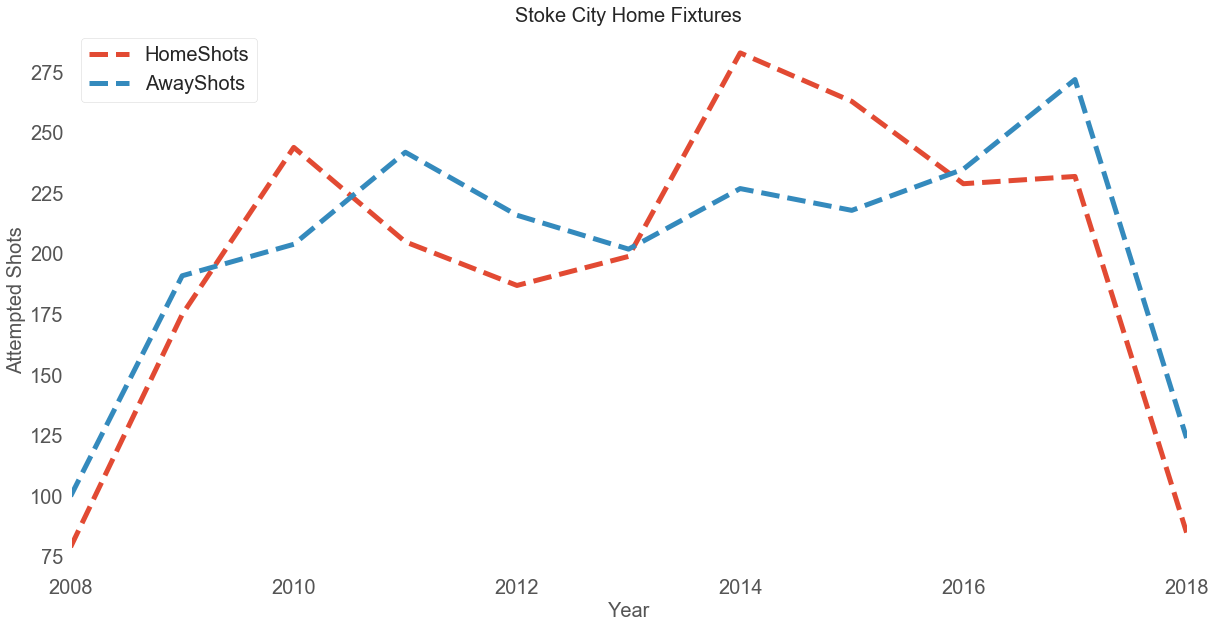

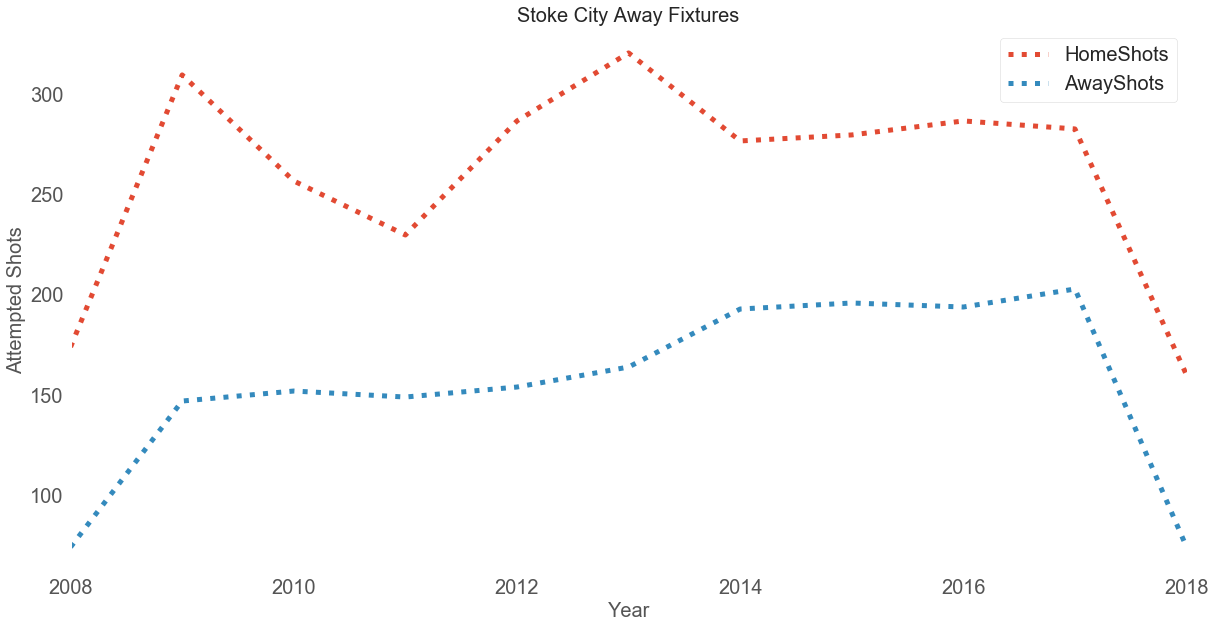

In [82]:
col=['HomeShots','AwayShots','HomeShotsOnTarget','AwayShotsOnTarget']
def create_shots_df(df,c):
    n_df=pd.DataFrame(df['Date'])
    for c in col:
        new_df=pd.DataFrame(df.groupby(df['Date'].dt.year)[col].sum())
    return new_df      
                                         
HM_shots=create_shots_df(Stoke_HMfixtures,col)
AW_shots=create_shots_df(Stoke_AWfixtures,col)
HM_shots
#AW_shots
plt.rcParams['axes.facecolor'] = 'w'
HM_shots[['HomeShots', 'AwayShots']].plot(figsize=(20,10), linewidth=5, fontsize=20,ls='--')
plt.xlabel('Year', fontsize=20)
plt.ylabel('Attempted Shots',fontsize=20)
#plt.legend(['Home Team shots_total','Away Team shots_total','Home Team shots_on_target_total','Away Team shots_on_target_total'],facecolor='white')
plt.title('Stoke City Home Fixtures',fontsize=20)
AW_shots[['HomeShots', 'AwayShots']].plot(figsize=(20,10), linewidth=5, fontsize=20,ls=':')
plt.xlabel('Year', fontsize=20)
plt.ylabel('Attempted Shots',fontsize=20)
#plt.legend(['Home Team shots_total','Away Team shots_total','Home Team shots_on_target_total','Away Team shots_on_target_total'],facecolor='white')
plt.title('Stoke City Away Fixtures',fontsize=20)

In [83]:
import matplotlib.pyplot as plt
from matplotlib.patches import Arc, Rectangle, ConnectionPatch
from matplotlib.offsetbox import  OffsetImage
from functools import reduce

def draw_pitch(ax):
    # size of the pitch is 120, 80
    #Create figure
    #Pitch Outline & Centre Line
    plt.plot([0,0],[0,80], color="w")
    plt.plot([0,120],[80,80], color="w")
    plt.plot([120,120],[80,0], color="w")
    plt.plot([120,0],[0,0], color="w")
    plt.plot([60,60],[0,80], color="w")

    #Left Penalty Area
    plt.plot([14.6,14.6],[57.8,22.2],color="w")
    plt.plot([0,14.6],[57.8,57.8],color="w")
    plt.plot([0,14.6],[22.2,22.2],color="w")

    #Right Penalty Area
    plt.plot([120,105.4],[57.8,57.8],color="w")
    plt.plot([105.4,105.4],[57.8,22.5],color="w")
    plt.plot([120, 105.4],[22.5,22.5],color="w")

    #Left 6-yard Box
    plt.plot([0,4.9],[48,48],color="w")
    plt.plot([4.9,4.9],[48,32],color="w")
    plt.plot([0,4.9],[32,32],color="w")

    #Right 6-yard Box
    plt.plot([120,115.1],[48,48],color="w")
    plt.plot([115.1,115.1],[48,32],color="w")
    plt.plot([120,115.1],[32,32],color="w")

    #Prepare Circles
    centreCircle = plt.Circle((60,40),8.1,color="w",fill=False)
    centreSpot = plt.Circle((60,40),0.71,color="w")
    leftPenSpot = plt.Circle((9.7,40),0.71,color="w")
    rightPenSpot = plt.Circle((110.3,40),0.71,color="w")

    #Draw Circles
    ax.add_patch(centreCircle)
    ax.add_patch(centreSpot)
    ax.add_patch(leftPenSpot)
    ax.add_patch(rightPenSpot)

    #Prepare Arcs
    # arguments for arc
    # x, y coordinate of centerpoint of arc
    # width, height as arc might not be circle, but oval
    # angle: degree of rotation of the shape, anti-clockwise
    # theta1, theta2, start and end location of arc in degree
    leftArc = Arc((9.7,40),height=16.2,width=16.2,angle=0,theta1=310,theta2=50,color="w")
    rightArc = Arc((110.3,40),height=16.2,width=16.2,angle=0,theta1=130,theta2=230,color="w")

    #Draw Arcs
    ax.add_patch(leftArc)
    ax.add_patch(rightArc)
    

In [84]:
# Image of football pitch

# #plt.style.use('dark_background')
# plt.rcParams['axes.facecolor'] = 'g'
# fig=plt.figure()
# fig.set_size_inches(15,10 )
# fig.set_facecolor("g")
# ax=fig.add_subplot(1,1,1)
# draw_pitch(ax)
# plt.show()

In [85]:
Club_Pts_Stoke=Club_Pts[Club_Pts['Team']=='Stoke City']
Club_Pts_Stoke=Club_Pts_Stoke.set_index(['Season'])
Club_Pts_Stoke.index.unique()

Index(['08-09', '09-10', '10-11', '11-12', '12-13', '13-14', '14-15', '15-16',
       '16-17', '17-18'],
      dtype='object', name='Season')

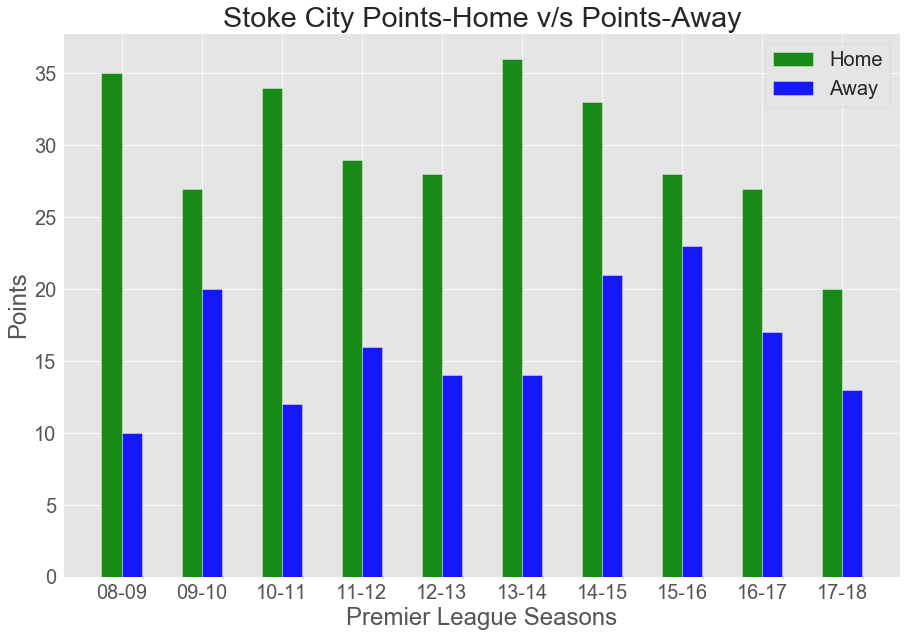

In [86]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize']=(15,10)
plt.rcParams.update({'font.size':20})
Stoke_Home= Club_Pts_Stoke['HomePoints']
Stoke_Away= Club_Pts_Stoke['AwayPoints']
fig, ax = plt.subplots()
index = np.arange(len(Club_Pts_Stoke.index))
bar_width = 0.25
opacity = 0.9
ax.bar(index, Stoke_Home, bar_width, alpha=opacity, color='g',
                label='Home')
ax.bar(index+bar_width, Stoke_Away, bar_width, alpha=opacity, color='b',
                label='Away')
ax.set_xlabel('Premier League Seasons')
ax.set_ylabel('Points')
ax.set_title('Stoke City Points-Home v/s Points-Away')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(Club_Pts_Stoke.index.unique())
ax.legend()
plt.show()

In [118]:
#Stoke City home games stats merged with weather data for each fixture
#Cities_wthr=['Stoke-on-Trent','London','Manchester','Liverpool']
def weather_by_city(df,Cities_wthr):
        df=df[df['City']==Cities_wthr]
        df['Date_Time']=pd.to_datetime(df['Date_Time'])
        df['Date']=pd.to_datetime(df['Date_Time'].dt.date)
        df['Time']=df['Date_Time'].dt.time
        df.drop(['Date_Time'],axis=1,inplace=True)
        df=df[['City','Date', 'Time','MintempC', 'MaxtempC', 'TempC', 'WindspeedKmph', 'WeatherDesc',
           'WinddirDegree', 'Winddir16Point', 'PrecipMM', 'Humidity', 'Visibility',
           'Pressure', 'Cloudcover', 'HeatIndexC', 'DewPointC', 'WindChillC',
           'WindGustKmph', 'FeelsLikeC', 'UvIndex']]
        return df   
            
Stoke_wthr=weather_by_city(weather,'Stoke-on-Trent')
London_wthr=weather_by_city(weather,'London')
Manchester_wthr=weather_by_city(weather,'Manchester')
Liverpool_wthr=weather_by_city(weather,'Liverpool')

Club_Fixtures_wthr=PremierLeague[['Season', 'Date','DayofWeek','Kickoff','HomeTeam','AwayTeam','HomeScore','AwayScore', 'Result','HomePoints','AwayPoints',
                                 'HomeFouls','AwayFouls']]
HME_Stoke_Fix=Club_Fixtures_wthr[Club_Fixtures_wthr['HomeTeam']=='Stoke City']
Stoke_wthr['City'] = Stoke_wthr['City'].map({'Stoke-on-Trent': 'Stoke City'})
HME_Stoke_Fix_wthr = pd.merge(HME_Stoke_Fix,Stoke_wthr, on ='Date',how='inner')
HME_Stoke_Fix_wthr.drop(['City','Time'],axis=1,inplace=True)
HME_Stoke_Fix_wthr.head(10)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-vie

,Season,Date,DayofWeek,Kickoff,HomeTeam,AwayTeam,HomeScore,AwayScore,Result,HomePoints,AwayPoints,HomeFouls,AwayFouls,MintempC,MaxtempC,TempC,WindspeedKmph,WeatherDesc,WinddirDegree,Winddir16Point,PrecipMM,Humidity,Visibility,Pressure,Cloudcover,HeatIndexC,DewPointC,WindChillC,WindGustKmph,FeelsLikeC,UvIndex
0,08-09,2008-08-23,Saturday,15:00:00,Stoke City,Aston Villa,3,2,H,3,0,15,5,0.0,0.0,18.0,12.0,Overcast,210.0,SSW,0.0,64.0,10.0,1012.0,90.0,18.0,11.0,18.0,17.0,18.0,4.0
1,08-09,2008-09-14,Sunday,13:30:00,Stoke City,Everton,2,3,A,0,3,10,19,0.0,0.0,17.0,12.0,Partly cloudy,116.0,ESE,0.0,66.0,10.0,1025.0,42.0,17.0,11.0,17.0,14.0,17.0,5.0
2,08-09,2008-09-27,Saturday,15:00:00,Stoke City,Chelsea,0,2,A,0,3,9,6,0.0,0.0,17.0,9.0,Sunny,222.0,SW,0.0,59.0,10.0,1029.0,0.0,19.0,11.0,19.0,10.0,19.0,5.0
3,08-09,2008-10-19,Sunday,16:00:00,Stoke City,Tottenham Hotspur,2,1,H,3,0,12,12,0.0,0.0,12.0,26.0,Overcast,204.0,SSW,0.0,80.0,10.0,1011.0,95.0,12.0,9.0,9.0,40.0,9.0,3.0
4,08-09,2008-10-29,Wednesday,19:45:00,Stoke City,Sunderland,1,0,H,3,0,10,8,0.0,0.0,3.0,18.0,Overcast,161.0,SSE,0.0,82.0,10.0,1000.0,92.0,3.0,0.0,-1.0,30.0,-1.0,1.0
5,08-09,2008-11-22,Saturday,15:00:00,Stoke City,West Bromwich Albion,1,0,H,3,0,9,7,0.0,0.0,3.0,20.0,Sunny,342.0,NNW,0.0,61.0,10.0,1018.0,5.0,3.0,-4.0,-2.0,31.0,-2.0,2.0
6,08-09,2008-11-29,Saturday,15:00:00,Stoke City,Hull City,1,1,D,1,1,17,20,0.0,0.0,3.0,6.0,Cloudy,4.0,N,0.0,87.0,10.0,996.0,87.0,3.0,1.0,1.0,9.0,1.0,1.0
7,08-09,2008-12-13,Saturday,15:00:00,Stoke City,Fulham,0,0,D,1,1,16,2,0.0,0.0,3.0,4.0,Fog,208.0,SSW,0.0,100.0,0.0,986.0,100.0,3.0,3.0,2.0,7.0,2.0,1.0
8,08-09,2008-12-26,Friday,12:45:00,Stoke City,Manchester United,0,1,A,0,3,13,7,0.0,0.0,4.0,17.0,Sunny,100.0,E,0.0,78.0,10.0,1040.0,3.0,4.0,0.0,0.0,23.0,0.0,2.0
9,08-09,2009-01-31,Saturday,12:45:00,Stoke City,Manchester City,1,0,H,3,0,9,9,6.0,6.0,5.0,24.0,Sunny,109.0,ESE,0.0,63.0,10.0,1010.0,11.0,5.0,-1.0,1.0,39.0,1.0,3.0


In [140]:
Liverpool_wthr.isna().count()

City              418
Date_Time         418
MintempC          418
MaxtempC          418
TempC             418
WindspeedKmph     418
WeatherDesc       418
WinddirDegree     418
Winddir16Point    418
PrecipMM          418
Humidity          418
Visibility        418
Pressure          418
Cloudcover        418
HeatIndexC        418
DewPointC         418
WindChillC        418
WindGustKmph      418
FeelsLikeC        418
UvIndex           418
dtype: int64

In [158]:
Stoke_wthr.groupby('Time')['MintempC'].mean()
London_wthr.groupby('Time')['MintempC'].mean()
Manchester_wthr.groupby('Time')['MintempC'].mean()
Liverpool_wthr.groupby('Time')['MintempC'].mean()

Time
12:00:00     9.250000
12:30:00    10.666667
12:45:00     9.952381
13:30:00    11.407407
13:37:00    12.000000
14:00:00     7.333333
14:05:00     9.800000
14:15:00     8.666667
15:00:00    10.475000
16:00:00    11.342105
16:10:00    14.000000
16:15:00    12.000000
16:30:00     8.750000
17:15:00     6.000000
17:30:00    10.441176
19:45:00     9.750000
20:00:00     8.827586
Name: MintempC, dtype: float64

Text(6.799999999999997, 0.5, 'Points won by away team')

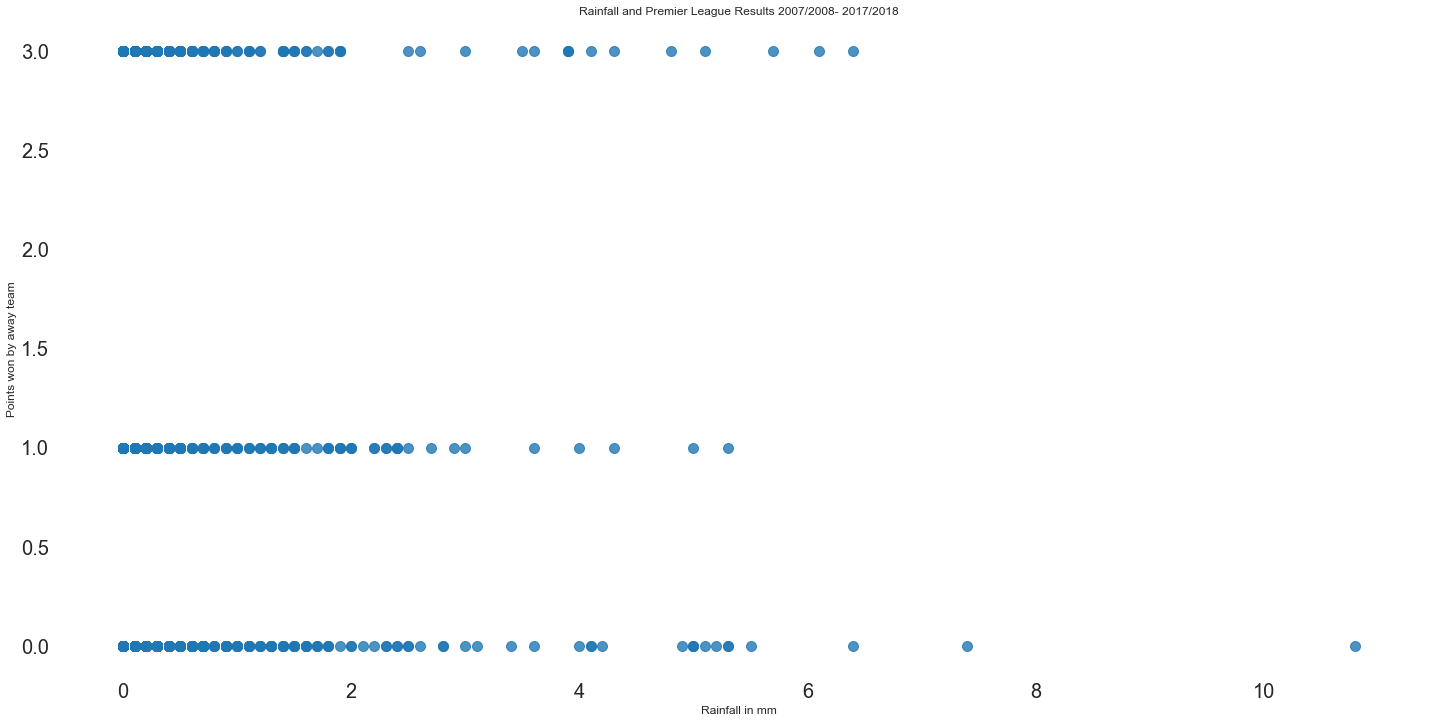

In [117]:
plt.rcParams['axes.facecolor'] = 'w'
rcParams['figure.figsize'] = 20,15
rcParams["scatter.marker"]='s'
ax = sns.lmplot('PrecipMM','AwayPoints', data=PremierLeague,fit_reg=False, height = 10,aspect =2,scatter_kws={"s": 100})
# def label_point(x, y, val, ax):
#     a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
#     for i, point in a.iterrows():
#         if point['val']=='Stoke City':
#             ax.text(point['x']+.02, point['y'], str(point['val']),fontsize=20)
  
plt.title('Rainfall and Premier League Results 2007/2008- 2017/2018')
# Set x-axis label
plt.xlabel('Rainfall in mm')
# Set y-axis label
plt.ylabel('Points won by away team')


Text(6.799999999999997, 0.5, 'Points won by away team')

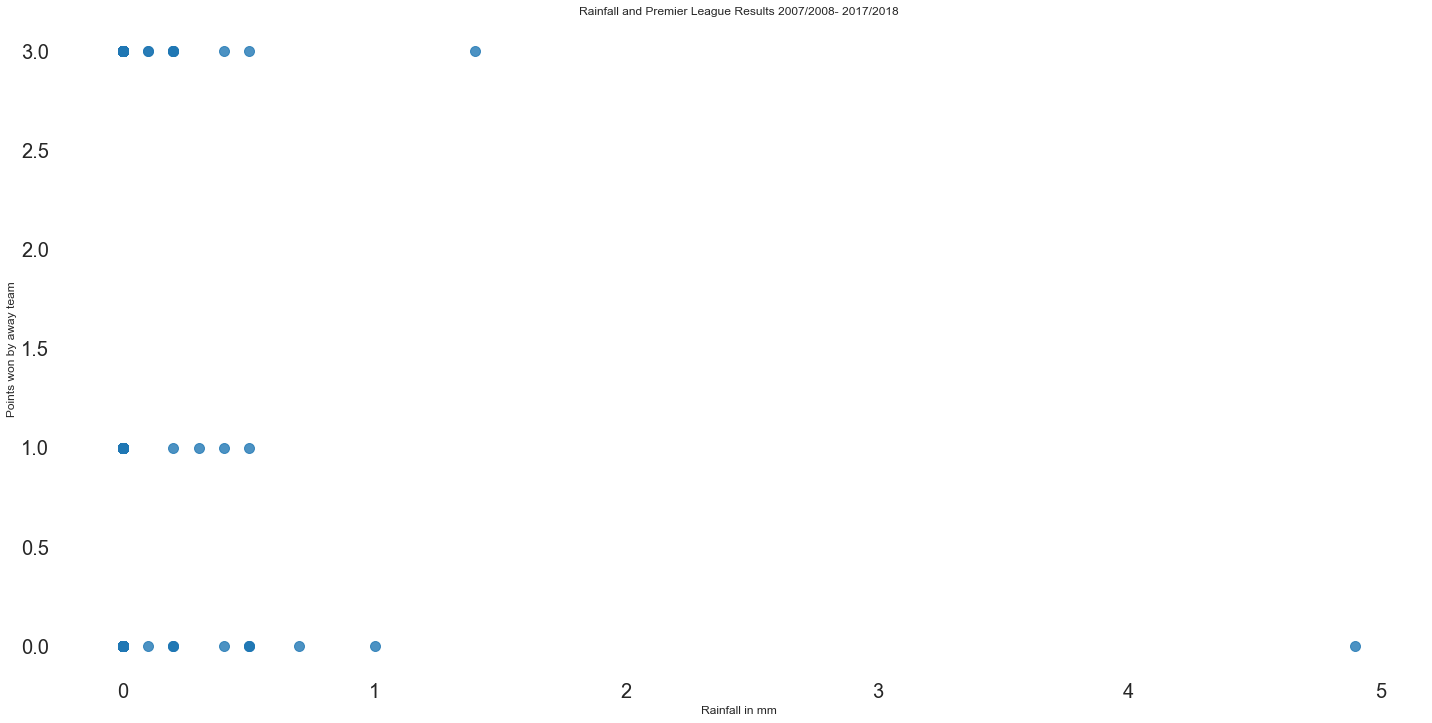

In [121]:
plt.rcParams['axes.facecolor'] = 'w'
rcParams['figure.figsize'] = 20,15
rcParams["scatter.marker"]='s'
ax = sns.lmplot('PrecipMM','AwayPoints', data=HME_Stoke_Fix_wthr, fit_reg=False, height = 10,aspect =2,scatter_kws={"s": 100})
# def label_point(x, y, val, ax):
#     a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
#     for i, point in a.iterrows():
#         if point['val']=='Stoke City':
#             ax.text(point['x']+.02, point['y'], str(point['val']),fontsize=20)
  
plt.title('Rainfall and Premier League Results 2007/2008- 2017/2018')
# Set x-axis label
plt.xlabel('Rainfall in mm')
# Set y-axis label
plt.ylabel('Points won by away team')



Text(12.424999999999997, 0.5, 'Points won by away team')

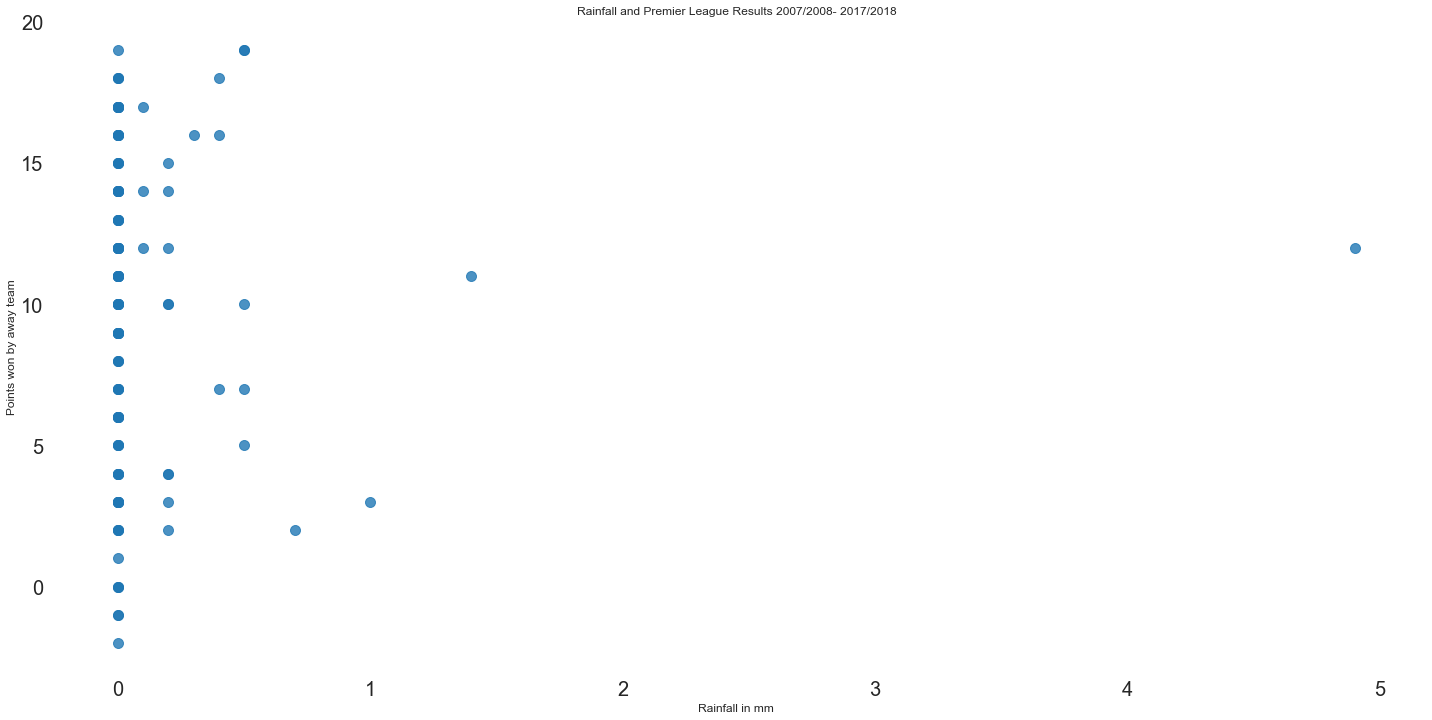

In [123]:
plt.rcParams['axes.facecolor'] = 'w'
rcParams['figure.figsize'] = 20,15
rcParams["scatter.marker"]='s'
ax = sns.lmplot('PrecipMM','TempC', data=HME_Stoke_Fix_wthr, fit_reg=False, height = 10,aspect =2,scatter_kws={"s": 100})
# def label_point(x, y, val, ax):
#     a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
#     for i, point in a.iterrows():
#         if point['val']=='Stoke City':
#             ax.text(point['x']+.02, point['y'], str(point['val']),fontsize=20)
  
plt.title('Rainfall and Premier League Results 2007/2008- 2017/2018')
# Set x-axis label
plt.xlabel('Rainfall in mm')
# Set y-axis label
plt.ylabel('Points won by away team')


